In [1]:
import pandas as pd
import os
import random
import numpy as np
import torch
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import json

import transformers
from transformers import CLIPProcessor, CLIPModel
from multilingual_clip import pt_multilingual_clip # Note: add device parameter to forward manually
import open_clip


from torch.utils.data import DataLoader, Dataset
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline

In [2]:
# loading variables from .env file
load_dotenv("../../private_data/.env") 

# PARENT gets us to the root of the project
PARENT = "./../../"

FOLDER_TABLE = PARENT + os.getenv("FOLDER_TABLE")
FILE_FABRITIUS_DATA = PARENT + os.getenv("FILE_FABRITIUS_DATA")
FILE_FABRITIUS_DATA_FILTERED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED")
FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED = PARENT + os.getenv("FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED")
FOLDER_FIGURES = PARENT + os.getenv("FOLDER_FIGURES")
IMAGES_FOLDER = PARENT + os.getenv("IMAGES_FOLDER")
RECORD_IDS_TESTING_SET = PARENT + os.getenv("RECORD_IDS_TESTING_SET")
RECORD_IDS_VALIDATION_SET = PARENT + os.getenv("RECORD_IDS_VALIDATION_SET")
WRITTEN_CAPTIONS_TESTING_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_TESTING_SET")
WRITTEN_CAPTIONS_VALIDATION_SET = PARENT + os.getenv("WRITTEN_CAPTIONS_VALIDATION_SET")
FILE_FABRITIUS_ICONOGRAPHIES_JSON = PARENT + os.getenv("FILE_FABRITIUS_ICONOGRAPHIES_JSON")

##

def fixPath(path):
    return path.replace(".././", "../")

def get_image_path_from_recordID(dataset, recordID):
    """
    Given a recordID, return the local path for its image.
    """
    # Locate row in the downloaded DataFrame
    paths = dataset[
        dataset["recordID"] == recordID
    ]["low_res_filename"].values
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    # Merge: IMAGES_FOLDER + path[1:]
    merged_path = fixPath(os.path.join(IMAGES_FOLDER, path[1:]))
    return merged_path

In [3]:
class ImageTextDataset(Dataset):
    def __init__(self, dataframe, preprocess, getImageFromRecordID):
        self.dataframe = dataframe
        self.preprocess = preprocess
        self.getImageFromRecordID = getImageFromRecordID

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        path = self.getImageFromRecordID(self.dataframe, row['recordID']) 
        image = Image.open(path)
        image = self.preprocess(image)  
        
        # Return image and caption (not used)
        return image, "empty"
    
class CLIPFromTransformerDataset(Dataset):
    def __init__(self, dataframe, getImageFromRecordID):
        self.dataframe = dataframe
        self.getImageFromRecordID = getImageFromRecordID

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        
        path = self.getImageFromRecordID(self.dataframe, row['recordID']) 
        image = Image.open(path)
        
        return image

In [4]:
FULL_DATASET = pd.read_csv(FILE_FABRITIUS_DATA_FILTERED_DOWNLOADED)
# Remove rows with corrupted images
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 11546]
FULL_DATASET = FULL_DATASET[FULL_DATASET["recordID"] != 5262]
FULL_DATASET = FULL_DATASET.sample(frac=1.0).reset_index(drop=True)
FULL_DATASET

recordLanguage  recordID DatabaseId  \
0               fre     11228  Fabritius   
1               fre      9351  Fabritius   
2               fre      6514  Fabritius   
3               fre      6543  Fabritius   
4               fre      5936  Fabritius   
...             ...       ...        ...   
3005            fre      4564  Fabritius   
3006            fre      7020  Fabritius   
3007            fre      4115  Fabritius   
3008            fre      4169  Fabritius   
3009            fre     10470  Fabritius   

                                            LinkToVubis  \
0     http://193.190.214.119/fabritiusweb/LinkToVubi...   
1     http://193.190.214.119/fabritiusweb/LinkToVubi...   
2     http://193.190.214.119/fabritiusweb/LinkToVubi...   
3     http://193.190.214.119/fabritiusweb/LinkToVubi...   
4     http://193.190.214.119/fabritiusweb/LinkToVubi...   
...                                                 ...   
3005  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3006  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3007  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3008  http://193.190.214.119/fabritiusweb/LinkToVubi...   
3009  http://193.190.214.119/fabritiusweb/LinkToVubi...   

        objectWork.creatorDescription         objectWork.termClassification  \
0     Pierre-Joseph Célestin François          peinture (Dept. Art Moderne)   
1                   Peter Paul Rubens  oeuvre sur papier (Dept. Art Ancien)   
2                Remigio Cantagallina  oeuvre sur papier (Dept. Art Ancien)   
3                Remigio Cantagallina  oeuvre sur papier (Dept. Art Ancien)   
4                Herman Saftleven III           peinture (Dept. Art Ancien)   
...                               ...                                   ...   
3005                 Guillaume Vogels          peinture (Dept. Art Moderne)   
3006                 François Boitard  oeuvre sur papier (Dept. Art Ancien)   
3007                      Firmin Baes          peinture (Dept. Art Moderne)   
3008                      Firmin Baes          peinture (Dept. Art Moderne)   
3009                     Victor Lagye          peinture (Dept. Art Moderne)   

     objectWork.workID                               objectWork.titleText  \
0                12551                              L'enlèvement d'Europe   
1                12257  La montée au Calvaire (à gauche) / Le Christ m...   
2            2994 / 49  Le Jardin de l'hôtel de Bournonville et le pav...   
3            2994 / 79                           Chiens. Baratte à chiens   
4                 2834                             Intérieur d'une grange   
...                ...                                                ...   
3005              5077                               Cabines sur la plage   
3006        4060 / 405                       Le sabbat. Scène fantastique   
3007         10999 / 8                                    Château et parc   
3008        10999 / 61                                Prairie avec fleurs   
3009          3010 / 1                                           Le titre   

                 objectWork.objectWorkType objectWork.measurementsDescription  \
0                      ['tableau (toile)']                     [230.0, 265.0]   
1     ['dessin aux 2 crayons', 'sanguine']                                NaN   
2                               ['dessin']                                NaN   
3                               ['dessin']                                NaN   
4                    ['tableau (panneau)']                       [41.0, 57.7]   
...                                    ...                                ...   
3005                 ['tableau (panneau)']                       [15.5, 25.0]   
3006                            ['dessin']                                NaN   
3007                 ['tableau (panneau)']                       [25.7, 19.0]   
3008                   ['tableau (toile)']                       [28.5, 40.5]   
30

In [5]:
# Load the iconographies (json file)
with open(FILE_FABRITIUS_ICONOGRAPHIES_JSON, "r", encoding="utf-8") as f:
    ICONOGRAPHIES = json.load(f)
len(ICONOGRAPHIES)

3010

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model_name = 'M-CLIP/XLM-Roberta-Large-Vit-B-16Plus'

# Load Model & Tokenizer
text_model = pt_multilingual_clip.MultilingualCLIP.from_pretrained(model_name)
text_tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)
text_model = text_model.to(device)
text_model.eval()
text_model.device

device(type='cuda', index=0)

In [8]:
openclip_model_name = "ViT-B-16-plus-240"
openclip_pretrained = "laion400m_e32"

image_model, _, image_preprocess = open_clip.create_model_and_transforms(openclip_model_name, pretrained=openclip_pretrained)
openclip_tokenizer = open_clip.get_tokenizer(openclip_model_name)
image_model = image_model.to(device)
image_model.eval()
print("CLIP model loaded")

CLIP model loaded


In [9]:
CLIP_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
CLIP_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
CLIP_model = CLIP_model.to(device)
CLIP_model.eval()
print("CLIP (finetuned) model loaded")

CLIP (finetuned) model loaded


In [10]:
selected_checkpoint = "LORA_own_dataset_CLIP_10_01_2025_00_17_51"
checkpoint_folder = "../models/clip/" + selected_checkpoint + "/model.pt"
model = CLIPModel.from_pretrained(checkpoint_folder).to(device)
model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [11]:
try:
    text_model.forward("test", text_tokenizer, device=device)
    print("GOOD: Model has been modified to allow for device in forward")
except:
    raise Exception("Model has not been modified to allow for device in forward !")

GOOD: Model has been modified to allow for device in forward


In [13]:
from transformers import pipeline

checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification", device_map="auto")

Device set to use cuda:0


In [14]:
# 0) Load data
def generatingEmbeddingsBatchBuilder(images):
    N = len(images)
    inputs = CLIP_processor(text=[""]*N, images=images, return_tensors="pt", padding=True, truncation=True)
    return inputs

dataset = ImageTextDataset(FULL_DATASET, image_preprocess, get_image_path_from_recordID)
dateset_transformer = CLIPFromTransformerDataset(FULL_DATASET, get_image_path_from_recordID)
dataloader = DataLoader(dataset, batch_size=2, num_workers=0)
dataloader_transformer = DataLoader(dateset_transformer, batch_size=2, num_workers=0, collate_fn=generatingEmbeddingsBatchBuilder)
print(len(dataloader), "batches")
print(len(dataloader_transformer), "batches")

1505 batches
1505 batches


In [15]:
# 1) Compute image embeddings
image_embeddings = torch.zeros(0, 640).to(device)
for images, _ in tqdm(dataloader):
    images = images.to(device)
    with torch.no_grad():
        image_features = image_model.encode_image(images)
    image_embeddings = torch.cat((image_embeddings, image_features), dim=0)    

# Normalize embeddings
image_embeddings = image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)
print("OK: Image embeddings normalized", image_embeddings.shape)

100%|██████████| 1505/1505 [01:35<00:00, 15.77it/s]

OK: Image embeddings normalized torch.Size([3010, 640])


In [16]:
# 2) Compute image embeddings with finetuned
finetuned_image_embeddings = torch.zeros(0, 512).to(device)
for sample in tqdm(dataloader_transformer):

    # Get the inputs and move them to the device
    input_ids = sample['input_ids'].to(device)
    attention_mask = sample['attention_mask'].to(device)
    pixel_values = sample['pixel_values'].to(device)

    N = len(pixel_values)

    with torch.no_grad():
        embeddings = CLIP_model.get_image_features(pixel_values=pixel_values)
        finetuned_image_embeddings = torch.cat((finetuned_image_embeddings, embeddings), dim=0)

# Normalize embeddings
finetuned_image_embeddings = finetuned_image_embeddings / image_embeddings.norm(dim=-1, keepdim=True)

print("OK: Finetuned image embeddings computed", len(finetuned_image_embeddings))

100%|██████████| 1505/1505 [00:27<00:00, 54.57it/s]

OK: Finetuned image embeddings computed 3010


In [17]:
def embed_mQuery(mQuery, device, embedding_method="M-CLIP"):
    if embedding_method == "M-CLIP":
        text_model.eval()
        with torch.no_grad():
            query_embedding = torch.zeros((1, 640)).to(device)
            for i, query in enumerate(mQuery):
                term, weight = query
                part = weight * text_model.forward(term, text_tokenizer, device=device) # Note: add device parameter to forward manually
                query_embedding += part
    elif embedding_method == "OpenCLIP":
        # Use the OpenCLIP model
        image_model.eval()
        with torch.no_grad():
            query_embedding = torch.zeros((1, 640)).to(device)
            for i, query in enumerate(mQuery):
                term, weight = query
                tokenized_terms = openclip_tokenizer([term]).to(device)
                part = weight * image_model.encode_text(tokenized_terms)
                query_embedding += part
    elif embedding_method == "CLIP":
        # Use the CLIP model
        CLIP_model.eval()
        with torch.no_grad():
            query_embedding = torch.zeros((1, 512)).to(device)
            for i, query in enumerate(mQuery):
                term, weight = query
                tokenized_terms = CLIP_processor(text=[term], return_tensors="pt", padding=True, truncation=True).to(device)
                part = weight * CLIP_model.get_text_features(input_ids=tokenized_terms["input_ids"], attention_mask=tokenized_terms["attention_mask"])
                query_embedding += part

    # Normalize
    query_embedding = query_embedding / query_embedding.norm(dim=-1, keepdim=True)

    return query_embedding

for embedding_method in ["M-CLIP", "OpenCLIP", "CLIP"]:
    print("Embedding method:", embedding_method)
    # 2) Compute query embeddings
    mQuery = [("Christ", 1.0), ("Mary", 1.0), ("Joseph", 1.0)]
    query_embedding = embed_mQuery(mQuery, device, embedding_method)
    print("OK: Query embedding", query_embedding.shape)

Embedding method: M-CLIP
OK: Query embedding torch.Size([1, 640])
Embedding method: OpenCLIP
OK: Query embedding torch.Size([1, 640])
Embedding method: CLIP
OK: Query embedding torch.Size([1, 512])


In [18]:
# Sample 10 random recordIDs from the dataset
def plotCandidates(candidates, query, answers=None):
    if answers is None:
        answers = {
            "N/A": [False] * len(candidates)
        }

    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    for i, ax in enumerate(axs.flat):
        recordID = candidates.iloc[i]["recordID"]
        path = get_image_path_from_recordID(candidates, recordID)
        image = Image.open(path)
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        # Add a red border if the answer is NO
        answerText = []
        for key in answers:
            answerText.append(f"{key}: {'YES' if answers[key][i] else 'NO'}")
        ax.set_title("\n".join(answerText))
    plt.suptitle(f"Query: {query}")
    plt.show()

In [19]:
def getObjectsFreq(iconography):
    frequency = {}
    def visit(node):
        value = node["value"]
        children = node["children"]

        isGroup = value == "<group>"
        isRoot = value == "root"

        if not isGroup and not isRoot:
            if value not in frequency:
                frequency[value] = 0
            frequency[value] += 1

        for child in children:
            visit(child)

    for recordID in iconography:
        visit(iconography[recordID])

    # Divide by the number of records
    for key in frequency:
        frequency[key] = frequency[key] / len(iconography)

    return frequency

In [20]:
from scipy.sparse import lil_matrix 
"""
Let's assume that each object has a specific threshold for the cosine similarity.
Using the iconography, we can estimate it !
"""
counts = getObjectsFreq(ICONOGRAPHIES)
print(len(counts), "unique objects")

# Order the objects by frequency
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

MIN_FREQ = 0.1#0.01 # Minimum frequency to consider an object

counts_filtered = {k: v for k, v in counts.items() if v > MIN_FREQ}
print(len(counts_filtered), "objects with frequency >=", MIN_FREQ)

counts_filtered_objects = list(counts_filtered.keys())
print(counts_filtered_objects)

1328 unique objects
12 objects with frequency >= 0.1
['figure', 'homme', 'groupe de figures', 'chapeau', 'femme', 'assis', 'animal', 'vêtement', 'enfant', 'paysage', 'arbre', 'scène']


In [21]:
# Sparse matrix: recordID x object
object_presence_per_recordID = lil_matrix((len(FULL_DATASET), len(counts_filtered_objects)), dtype=bool)
print(object_presence_per_recordID.shape)

for recordIndex, row in FULL_DATASET.iterrows():
    recordID = row["recordID"]
    iconography = ICONOGRAPHIES[str(recordID)]
    def visit(node):
        value = node["value"]
        children = node["children"]

        isInFiltered = value in counts_filtered_objects

        if isInFiltered:
            objectIndex = list(counts_filtered_objects).index(value)
            try:
                object_presence_per_recordID[recordIndex, objectIndex] = True
            except:
                print(recordIndex, objectIndex)
                raise Exception("Error")

        for child in children:
            visit(child)

    visit(iconography)

number_of_non_zero_elements = object_presence_per_recordID.count_nonzero()
print(number_of_non_zero_elements, "non-zero elements out of ", object_presence_per_recordID.shape[0] * object_presence_per_recordID.shape[1])

(3010, 12)
8252 non-zero elements out of  36120


In [22]:
counts_filtered_objects = ['figure',
 'homme',
 'groupe de figures',
 'chapeau',
 'femme',
 'assis',
 'animal',
 'vêtement',
 'enfant',
 'paysage',
 'arbre',
 'scène']

In [23]:
objects_FR_to_EN = {
    "figure": "a person",
    "homme": "a man",
    "groupe de figures": "a group of people",
    "chapeau": "a hat",
    "femme": "a woman",
    "assis": "a person sitted",
    "animal": "an animal",
    "vêtement": "a piece of clothing",
    "enfant": "a child",
    "paysage": "a landscape",
    "arbre": "a tree",
    "scène": "a scene"
}
objects_FR_to_FR = {
    "figure": "une personne",
    "homme": "un homme",
    "groupe de figures": "un groupe de personnes",
    "chapeau": "un chapeau",
    "femme": "une femme",
    "assis": "une personne assise",
    "animal": "un animal",
    "vêtement": "un vêtement",
    "enfant": "un enfant",
    "paysage": "un paysage",
    "arbre": "un arbre",
    "scène": "une scène"
}

In [24]:
objects_names = list(objects_FR_to_EN.keys())
accuracies = {}
precisions = {}
recalls = {}
thresholds = {}
embedding_methods = ["M-CLIP", "OpenCLIP", "CLIP"]
similarityMetric = "cosine"

In [25]:
def plotPrecisionAndRecall():
    # Two subplots, one for precision, one for recall
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    for i, (name, values) in enumerate(precisions.items()):
        axs[0].plot(objects_names, values, label=name)
    axs[0].set_title("Precision")
    axs[0].legend()
    axs[0].set_ylim([0, 1])
    # Rotate x-axis labels
    for tick in axs[0].get_xticklabels():
        tick.set_rotation(45)
    
    for i, (name, values) in enumerate(recalls.items()):
        axs[1].plot(objects_names, values, label=name)
    axs[1].set_title("Recall")
    axs[1].legend()
    axs[1].set_ylim([0, 1])
    # Rotate x-axis labels
    for tick in axs[1].get_xticklabels():
        tick.set_rotation(45)

    plt.show()

In [85]:
def getSimilarities(A, B, variant="cosine"):
    # Output shape : (1, N)
    if variant == "cosine":
        similarities = cosine_similarity(A.cpu().detach().numpy(), B.cpu().numpy())
    elif variant == "dist":
        similarities = -torch.cdist(A, B).cpu().detach().numpy()
    elif variant == "dot":
        similarities = (A @ B.T).cpu().detach().numpy()
    return similarities

In [27]:
PREFIX = "MONO-"

for embedding_method in embedding_methods:
    this_accuracies = []
    this_precisions = []
    this_recalls = []
    this_thresholds = []
    for objectIndex, object in enumerate(objects_names):

        if embedding_method == "CLIP":        
            query = "Une image avec " + objects_FR_to_FR[object]
        else:
            query = "An image with " + objects_FR_to_EN[object]

        object_embedding = embed_mQuery([(query, 1.0)], device, embedding_method=embedding_method)
        object_embedding = object_embedding / object_embedding.norm(dim=-1, keepdim=True)

        # Compute cosine similarity
        if embedding_method == "CLIP":
            # different image embeddings
            similarities = getSimilarities(object_embedding, finetuned_image_embeddings, variant=similarityMetric)
        else:
            similarities = getSimilarities(object_embedding, image_embeddings, variant=similarityMetric)

        # Find the threshold needed to get the correct predictions
        similarities_with_object = similarities[0, object_presence_per_recordID[:, objectIndex].toarray().flatten()]
        similarities_without_object = similarities[0, ~object_presence_per_recordID[:, objectIndex].toarray().flatten()]
        
        # Find the threshold that separates the two distributions the best
        thresholds_cand = np.linspace(
            np.amin(similarities_without_object),
            np.amax(similarities_with_object),
            200
        )

        best_accuracy = -1
        best_recall = -1
        best_precision = -1

        best_threshold = None

        for threshold in thresholds_cand:
            TP, FP, TN, FN = 0, 0, 0, 0
            for similarity in similarities_with_object: # True positives
                if similarity > threshold:
                    TP += 1
                else:
                    FN += 1
            for similarity in similarities_without_object: # True negatives
                if similarity < threshold:
                    TN += 1
                else:
                    FP += 1

            if (TP + FN) == 0:
                recall = 0
            else:
                recall = TP / (TP + FN)
            
            if (TP + FP) == 0:
                precision = 0
            else:
                precision = TP / (TP + FP)

            accuracy = (TP + TN) / (TP + TN + FP + FN)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_precision = precision
                best_recall = recall
                best_threshold = threshold
            
        this_accuracies.append(best_accuracy)
        this_precisions.append(best_precision)
        this_recalls.append(best_recall)
        this_thresholds.append(best_threshold)

    accuracies[PREFIX + embedding_method] = this_accuracies
    precisions[PREFIX + embedding_method] = this_precisions
    recalls[PREFIX + embedding_method] = this_recalls
    thresholds[PREFIX + embedding_method] = this_thresholds

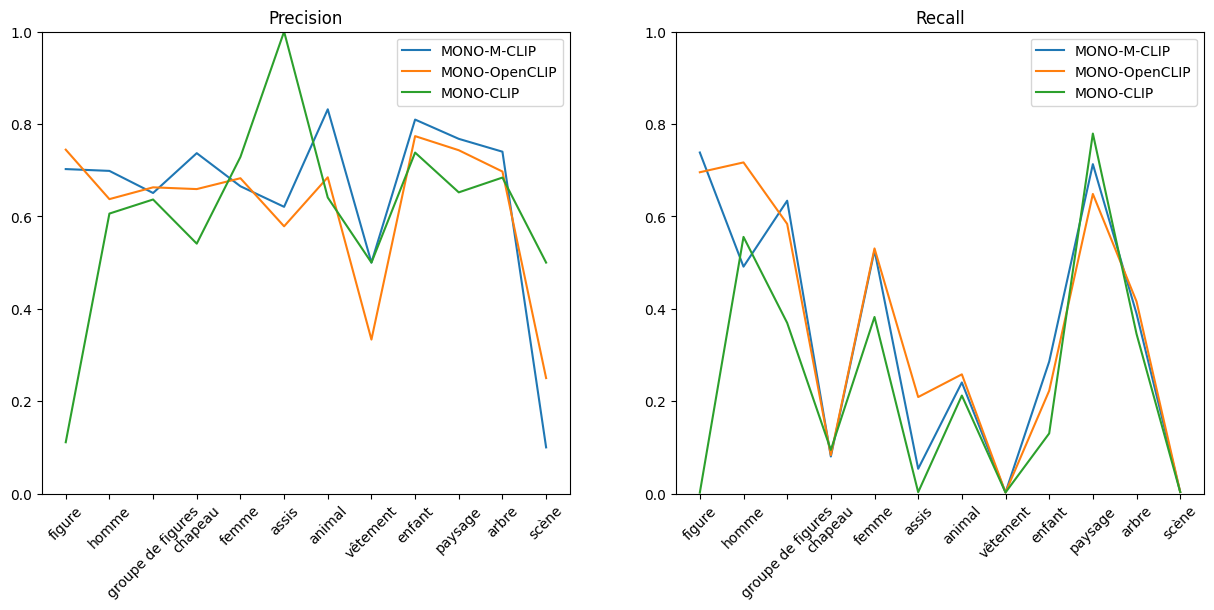

In [28]:
plotPrecisionAndRecall()

In [29]:
objects_FR_to_EN_multi = {
    "figure": ["a person", "a figure", "a character", "a human", "a man", "a woman", "a child"],
    "homme": ["a man", "a sir", "a gentleman"],
    "groupe de figures": ["a group of people", "a crowd", "a gathering"],
    "chapeau": ["a hat", "a cap", "a headwear"],
    "femme": ["a woman", "a lady"],
    "assis": ["a person sitted", "a person sitting", "a person seated"],
    "animal": ["an animal", "a beast", "a creature", "a dog", "a cat", "a bird", "a fish"],
    "vêtement": ["a piece of clothing", "a garment", "a dress", "a shirt", "a coat", "a jacket", "a pair of pants", "a pair of shoes"],
    "enfant": ["a child", "a kid", "a baby", "a toddler", "a little boy", "a little girl"],
    "paysage": ["a landscape", "a scenery", "a view", "a panorama", "a vista"],
    "arbre": ["a tree", "a forest"],
    "scène": ["a scene", "a setting", "a backdrop", "a stage"]
}
objects_FR_to_FR_multi = {
    "figure": ["une personne", "une figure", "un personnage", "un humain", "un homme", "une femme", "un enfant"],
    "homme": ["un homme", "un monsieur", "un gentilhomme"],
    "groupe de figures": ["un groupe de personnes", "une foule", "une assemblée"],
    "chapeau": ["un chapeau", "une casquette", "une coiffe"],
    "femme": ["une femme", "une dame"],
    "assis": ["une personne assise", "une personne assis", "une personne assise"],
    "animal": ["un animal", "une bête", "une créature", "un chien", "un chat", "un oiseau", "un poisson"],
    "vêtement": ["un vêtement", "un habit", "une robe", "une chemise", "un manteau", "une veste", "un pantalon", "une paire de chaussures"],
    "enfant": ["un enfant", "un gamin", "un bébé", "un bambin", "un petit garçon", "une petite fille"],
    "paysage": ["un paysage", "un panorama", "une vue", "un décor", "une scène"],
    "arbre": ["un arbre", "une forêt"],
    "scène": ["une scène", "un décor", "un fond", "une mise en scène"]
}

In [30]:
PREFIX = "MULTI-"

for embedding_method in embedding_methods:
    this_precisions = []
    this_recalls = []
    this_thresholds = []
    this_accuracies = []
    for objectIndex, object in enumerate(objects_names):

        if embedding_method == "CLIP":        
            objectsList = objects_FR_to_FR_multi[object]
            query = lambda term: "Une image avec " + term
        else:
            objectsList = objects_FR_to_EN_multi[object]
            query = lambda term: "An image with " + term

        objects_embeddings = []
        for term in objectsList:
            object_embedding = embed_mQuery([(query(term), 1.0)], device, embedding_method=embedding_method)
            object_embedding = object_embedding / object_embedding.norm(dim=-1, keepdim=True)
            objects_embeddings.append(object_embedding)

        # Compute cosine similarity for each object
        similarities_multi = []
        for i, object_embedding in enumerate(objects_embeddings):

            # Compute cosine similarity
            if embedding_method == "CLIP":
                # different image embeddings
                similarities = getSimilarities(object_embedding, finetuned_image_embeddings, variant=similarityMetric)
            else:
                similarities = getSimilarities(object_embedding, image_embeddings, variant=similarityMetric)

            similarities_multi.append(similarities)

        similarities_multi = np.array(similarities_multi)
        acc_similarity = np.mean(similarities_multi, axis=0)

        # Find the threshold needed to get the correct predictions
        similarities_with_object = acc_similarity[0, object_presence_per_recordID[:, objectIndex].toarray().flatten()]
        similarities_without_object = acc_similarity[0, ~object_presence_per_recordID[:, objectIndex].toarray().flatten()]
        
        # Find the threshold that separates the two distributions the best
        thresholds_cand = np.linspace(
            0,
            1,
            200
        )

        best_accuracy = -1
        best_recall = -1
        best_precision = -1

        best_threshold = None

        for threshold in thresholds_cand:
            TP, FP, TN, FN = 0, 0, 0, 0
            for similarity in similarities_with_object: # True positives
                if similarity > threshold:
                    TP += 1
                else:
                    FN += 1
            for similarity in similarities_without_object: # True negatives
                if similarity < threshold:
                    TN += 1
                else:
                    FP += 1

            if (TP + FN) == 0:
                recall = 0
            else:
                recall = TP / (TP + FN)
            
            if (TP + FP) == 0:
                precision = 0
            else:
                precision = TP / (TP + FP)

            accuracy = (TP + TN) / (TP + TN + FP + FN)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_precision = precision
                best_recall = recall
                best_threshold = threshold

        
        this_precisions.append(best_precision)
        this_recalls.append(best_recall)
        this_thresholds.append(best_threshold)
        this_accuracies.append(best_accuracy)

    accuracies[PREFIX + embedding_method] = this_accuracies
    precisions[PREFIX + embedding_method] = this_precisions
    recalls[PREFIX + embedding_method] = this_recalls
    thresholds[PREFIX + embedding_method] = this_thresholds

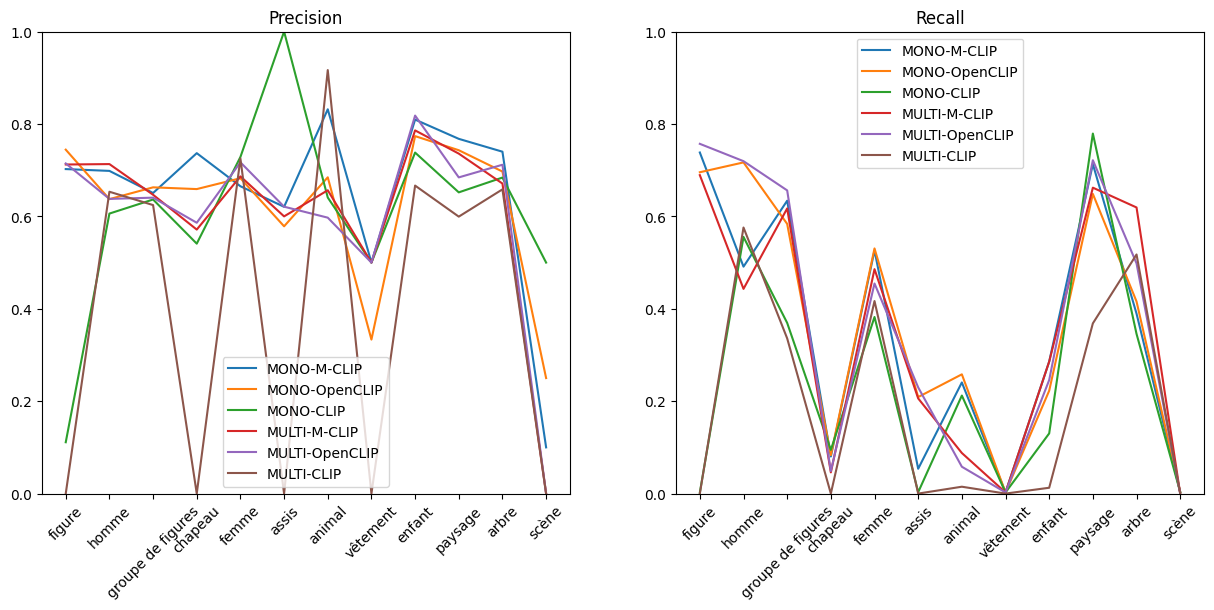

In [31]:
plotPrecisionAndRecall()

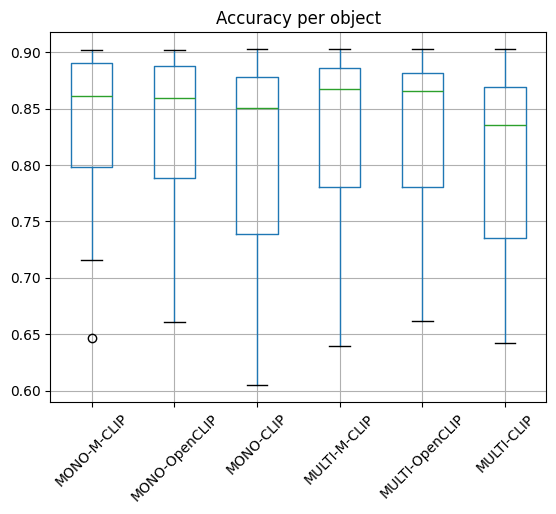

MONO-M-CLIP       0.829291
MONO-OpenCLIP     0.828904
MONO-CLIP         0.802769
MULTI-M-CLIP      0.824945
MULTI-OpenCLIP    0.827187
MULTI-CLIP        0.800498
dtype: float64


In [32]:
# Boxplot for the accuracies per embedding method
accuracies_df = pd.DataFrame(accuracies)
accuracies_df.boxplot()
plt.title("Accuracy per object")
plt.xticks(rotation=45)
plt.show()
means = accuracies_df.mean()
print(means)

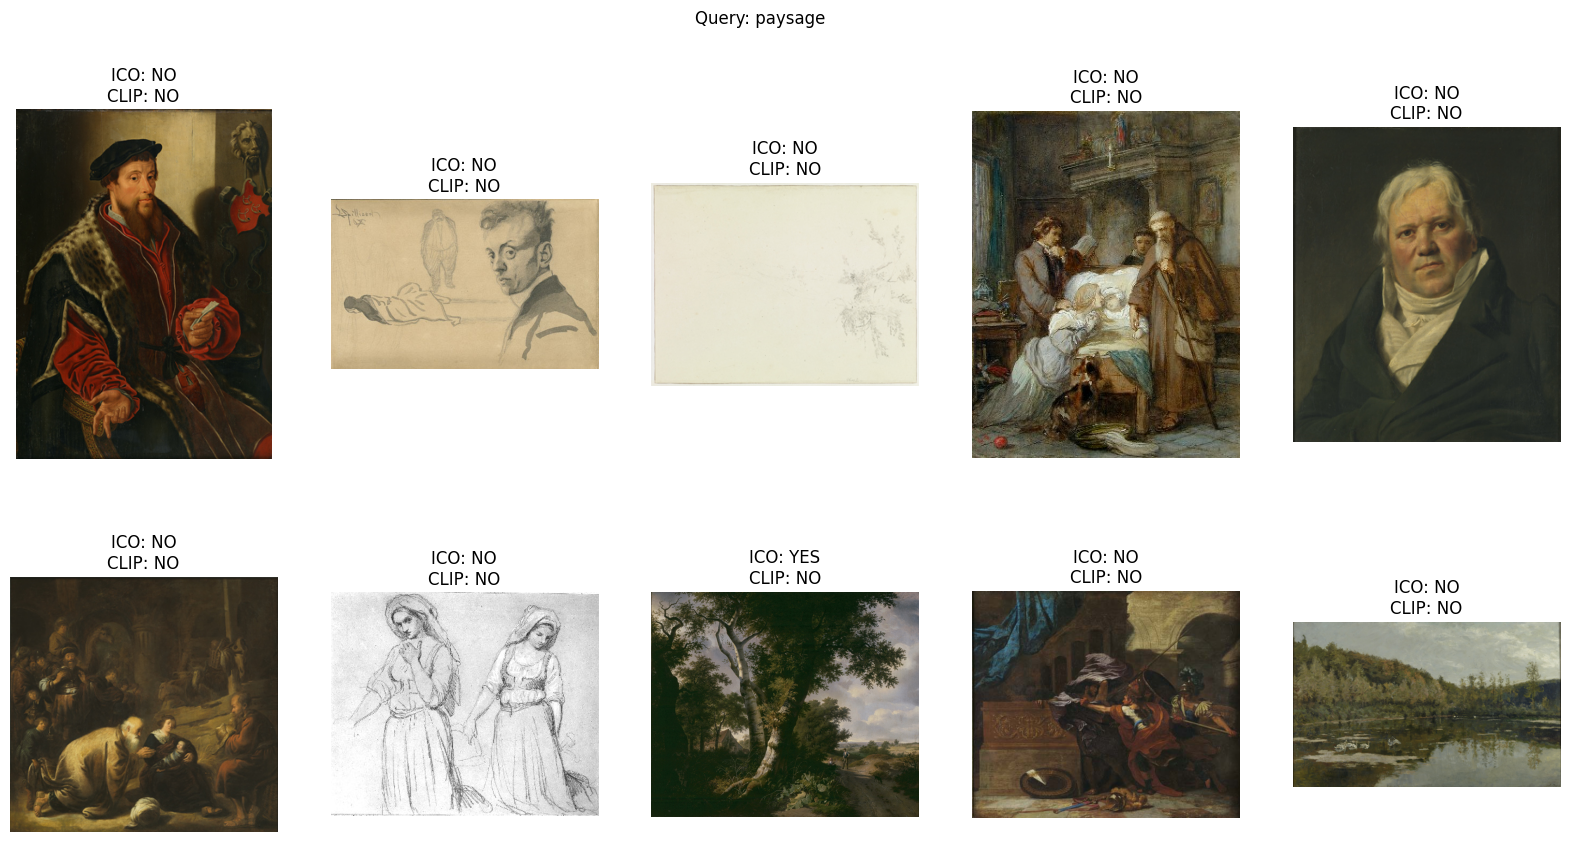

In [33]:
def get_answers(candidates, threshold, term):
    # Get embeddings for each candidate
    candidatesIndexes = candidates.index
    candidate_embeddings = finetuned_image_embeddings[candidatesIndexes]

    # Get logits for each candidate
    query_embedding = embed_mQuery([(f"Une image avec " + term, 1.0)], device, embedding_method="CLIP")
    similarities = cosine_similarity(query_embedding.cpu(), candidate_embeddings.cpu())
    similarities = similarities.squeeze()

    # Threshold
    answers = similarities > threshold
    return answers

def get_answers_ico(candidates, term):
    # Get embeddings for each candidate
    candidatesIndexes = candidates.index
    iconographies = object_presence_per_recordID[candidatesIndexes]
    termIndex = counts_filtered_objects.index(term)
    answers = iconographies[:, termIndex].toarray().flatten()
    return answers


candidates = FULL_DATASET.sample(10)

index = 9
answers_ico = get_answers_ico(candidates, objects_names[index])
answers_clip = get_answers(candidates, thresholds["MONO-M-CLIP"][index], objects_names[index])
plotCandidates(candidates, objects_names[index], answers={
    "ICO": answers_ico,
    "CLIP": answers_clip
})

In [34]:
# Let's define an object embedding by the mean embedding of the images that contain it
def getMeanContainerEmbedding(image_embeddings):
    imagesWithObject = object_presence_per_recordID[:, objectIndex].toarray().flatten()
    imagesWithObjectIndexes = np.where(imagesWithObject)[0]
    object_embedding = image_embeddings[imagesWithObjectIndexes].mean(dim=0)

    return object_embedding

mean_object_embeddings = {}
mean_object_embeddings_finetuned = {}

for objectIndex, object in enumerate(objects_names):
    mean_object_embeddings[object] = getMeanContainerEmbedding(image_embeddings)
    mean_object_embeddings_finetuned[object] = getMeanContainerEmbedding(finetuned_image_embeddings)

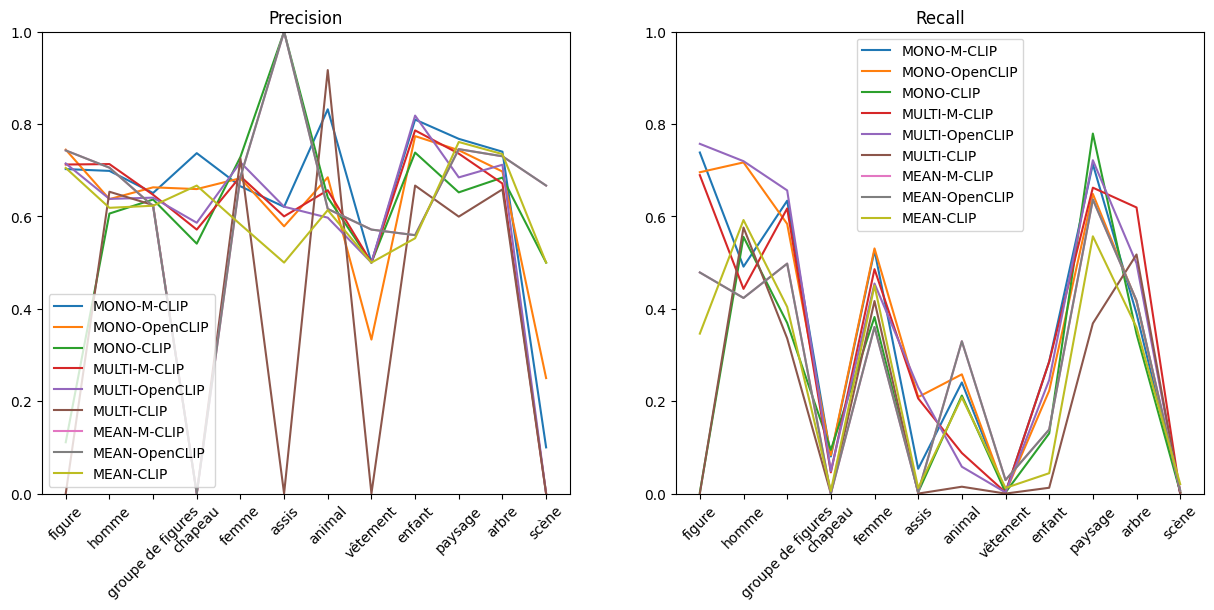

In [35]:
PREFIX = "MEAN-"

for embedding_method in embedding_methods:
    this_accuracies = []
    this_precisions = []
    this_recalls = []
    this_thresholds = []
    for objectIndex, object in enumerate(objects_names):

        if embedding_method == "CLIP":
            # different image embeddings
            object_embedding = mean_object_embeddings_finetuned[object].unsqueeze(0)
            similarities = getSimilarities(object_embedding, finetuned_image_embeddings, variant=similarityMetric)
        else:
            object_embedding = mean_object_embeddings[object].unsqueeze(0)
            similarities = getSimilarities(object_embedding, image_embeddings, variant=similarityMetric)

        # Find the threshold needed to get the correct predictions
        similarities_with_object = similarities[0, object_presence_per_recordID[:, objectIndex].toarray().flatten()]
        similarities_without_object = similarities[0, ~object_presence_per_recordID[:, objectIndex].toarray().flatten()]
        
        # Find the threshold that separates the two distributions the best
        thresholds_cand = np.linspace(
            np.amin(similarities_without_object),
            np.amax(similarities_with_object),
            200
        )

        best_accuracy = -1
        best_recall = -1
        best_precision = -1

        best_threshold = None

        for threshold in thresholds_cand:
            TP, FP, TN, FN = 0, 0, 0, 0
            for similarity in similarities_with_object: # True positives
                if similarity > threshold:
                    TP += 1
                else:
                    FN += 1
            for similarity in similarities_without_object: # True negatives
                if similarity < threshold:
                    TN += 1
                else:
                    FP += 1

            if (TP + FN) == 0:
                recall = 0
            else:
                recall = TP / (TP + FN)
            
            if (TP + FP) == 0:
                precision = 0
            else:
                precision = TP / (TP + FP)

            accuracy = (TP + TN) / (TP + TN + FP + FN)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_precision = precision
                best_recall = recall
                best_threshold = threshold
            
        this_accuracies.append(best_accuracy)
        this_precisions.append(best_precision)
        this_recalls.append(best_recall)
        this_thresholds.append(best_threshold)

    accuracies[PREFIX + embedding_method] = this_accuracies
    precisions[PREFIX + embedding_method] = this_precisions
    recalls[PREFIX + embedding_method] = this_recalls
    thresholds[PREFIX + embedding_method] = this_thresholds

plotPrecisionAndRecall()


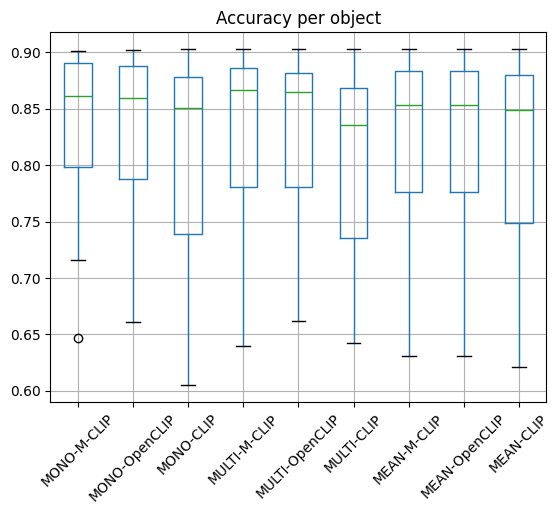

MONO-M-CLIP       0.829291
MONO-OpenCLIP     0.828904
MONO-CLIP         0.802769
MULTI-M-CLIP      0.824945
MULTI-OpenCLIP    0.827187
MULTI-CLIP        0.800498
MEAN-M-CLIP       0.814950
MEAN-OpenCLIP     0.814950
MEAN-CLIP         0.805786
dtype: float64


In [36]:
# Boxplot for the accuracies per embedding method
accuracies_df = pd.DataFrame(accuracies)
accuracies_df.boxplot()
plt.title("Accuracy per object")
plt.xticks(rotation=45)
plt.show()
means = accuracies_df.mean()
print(means)

In [72]:
for i,obj in enumerate(objects_names):
    print(i, obj)

0 figure
1 homme
2 groupe de figures
3 chapeau
4 femme
5 assis
6 animal
7 vêtement
8 enfant
9 paysage
10 arbre
11 scène


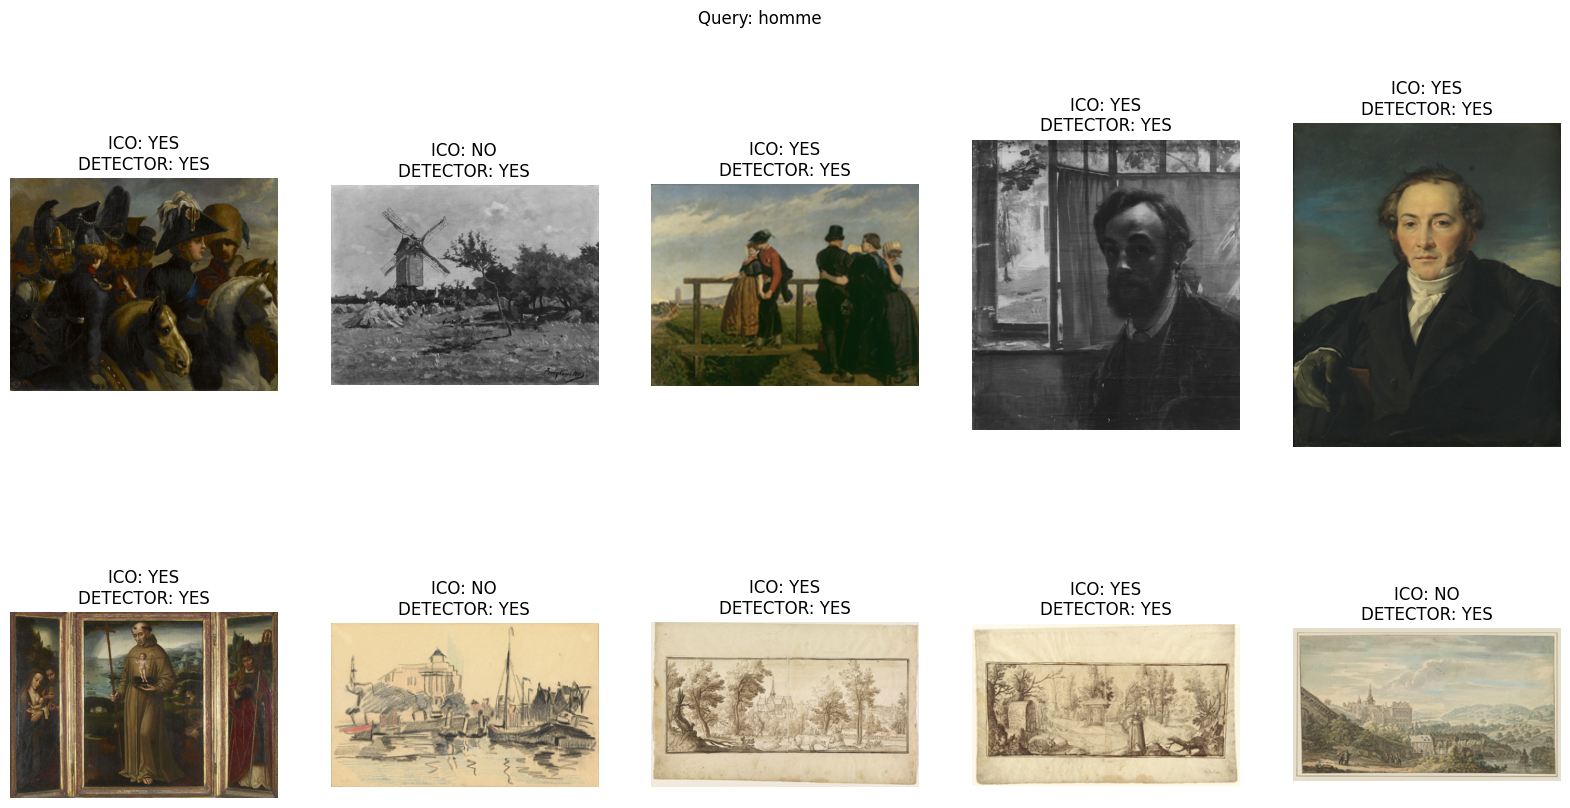

In [151]:
candidates = FULL_DATASET.sample(10)

def get_answers_detector(candidates, term):
    answers = []
    p_term = f"{objects_FR_to_EN[term]}"
    p_term_opp = f"{objects_FR_to_EN[term]}"

    for recordID in candidates["recordID"]:
        break
        image = Image.open(get_image_path_from_recordID(FULL_DATASET, recordID))
        predictions = detector(image, candidate_labels=[p_term, p_term_opp])
        probaForTerm = -1
        for prediction in predictions:
            if prediction["label"] == p_term:
                probaForTerm = prediction["score"]

        answers.append(probaForTerm > 0.5)

    # compute manually
    for recordID in candidates["recordID"]:
        indexInDataset = FULL_DATASET[FULL_DATASET["recordID"] == recordID].index[0]
        image_embedding = image_embeddings[indexInDataset]
        # Compute term embedding
        term_embedding = embed_mQuery([(p_term, 1.0)], device, embedding_method="M-CLIP")
        term_embedding = term_embedding / term_embedding.norm(dim=-1, keepdim=True)
        term_cos = getSimilarities(term_embedding, image_embedding.unsqueeze(0), variant="cosine")
        term_cos = term_cos[0][0]

        #term_embedding_opp = embed_mQuery([(p_term_opp, 1.0)], device, embedding_method="M-CLIP")
        #term_embedding_opp = term_embedding_opp / term_embedding_opp.norm(dim=-1, keepdim=True)
        term_embedding_opp = -term_embedding
        term_opp_cos = getSimilarities(term_embedding_opp, image_embedding.unsqueeze(0), variant="cosine")
        term_opp_cos = term_opp_cos[0][0]

        # Apply softmax
        cos_values = np.array([term_cos, term_opp_cos])
        probas = []

        for cos in cos_values:
            proba = np.exp(cos)
            probas.append(proba)
        probas = np.array(probas)
        probas /= np.sum(probas)

        answers.append(probas[0] > 0.5)

    return answers

index = 1
answers_ico = get_answers_ico(candidates, objects_names[index])
answers_detector = get_answers_detector(candidates, objects_names[index])
plotCandidates(candidates, objects_names[index], answers={
    "ICO": answers_ico,
    "DETECTOR": answers_detector
})

In [158]:
from transformers import ViltProcessor
from transformers import ViltForQuestionAnswering 

VILT_processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-mlm")
VILT_model = ViltForQuestionAnswering.from_pretrained("dandelin/vilt-b32-mlm")

preprocessor_config.json:   0%|          | 0.00/251 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/320 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/653 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of ViltForQuestionAnswering were not initialized from the model checkpoint at dandelin/vilt-b32-mlm and are newly initialized: ['classifier.0.bias', 'classifier.0.weight', 'classifier.1.bias', 'classifier.1.weight', 'classifier.3.bias', 'classifier.3.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

tensor([[-1.0560, -0.1615]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.3215,  0.6698]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.7139, -0.0375]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.5969, -0.2262]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.7161, -0.1057]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.7164,  0.0075]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.4746,  0.1365]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.2815,  0.3110]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.2968,  0.2631]], grad_fn=<AddmmBackward0>) 1 LABEL_1
tensor([[-0.3754,  0.3312]], grad_fn=<AddmmBackward0>) 1 LABEL_1


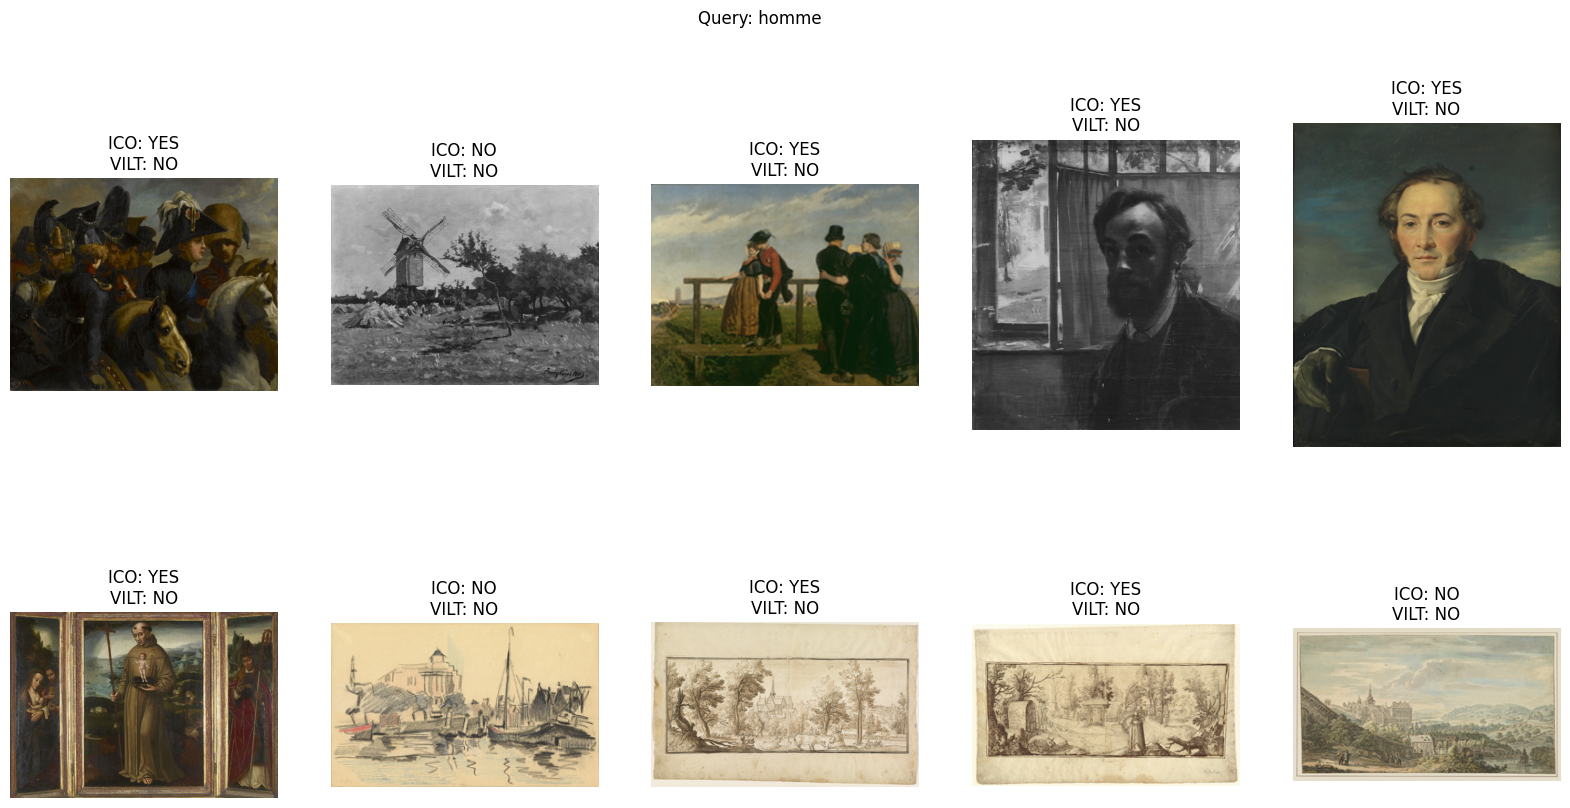

In [163]:
def get_answers_vilt(candidates, term):
    answers = []
    question = f"Does this image contain {objects_FR_to_EN[term]}?"

    for recordID in candidates["recordID"]:
        image = Image.open(get_image_path_from_recordID(FULL_DATASET, recordID))

        encoding = VILT_processor(image, question, return_tensors="pt")
        outputs = VILT_model(**encoding)
        logits = outputs.logits
        idx = torch.sigmoid(logits).argmax(-1).item()
        answer = VILT_model.config.id2label[idx]
        print(logits, idx, answer)
        if answer == "yes":
            answers.append(True)
        else:
            answers.append(False)

    return answers

index = 1
answers_ico = get_answers_ico(candidates, objects_names[index])
answers_vilt = get_answers_vilt(candidates, objects_names[index])
plotCandidates(candidates, objects_names[index], answers={
    "ICO": answers_ico,
    "VILT": answers_vilt
})

[{'scores': tensor([0.4438], device='cuda:0'), 'labels': ['homme'], 'boxes': tensor([[  0.8012,   0.7312, 420.8475, 222.9529]], device='cuda:0')}]


IndexError: list index out of range

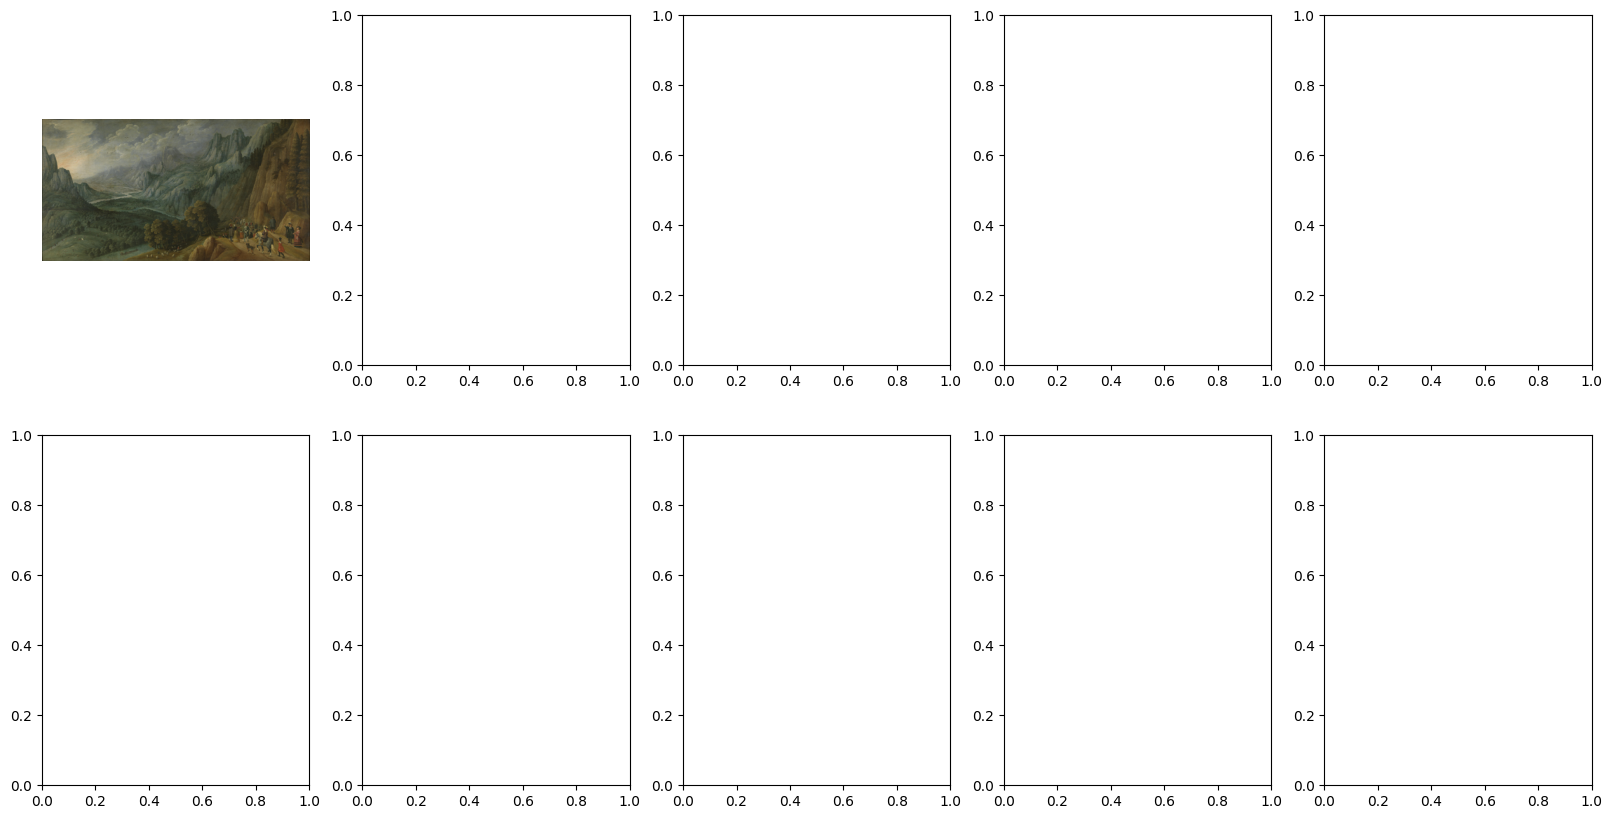

In [193]:
def get_answers_dino(candidates, term):
    answers = []
    
    for recordID in candidates["recordID"]:
        image = Image.open(get_image_path_from_recordID(FULL_DATASET, recordID))
        inputs = DINO_processor(image, text=term+".", return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = DINO_model(**inputs)
        results = DINO_processor.post_process_grounded_object_detection(
            outputs,
            inputs.input_ids,
            box_threshold=0.4,
            text_threshold=0.3,
            target_sizes=[image.size[::-1]]
        )
        print(results)
        break

    return answers

index = 1
answers_ico = get_answers_ico(candidates, objects_names[index])
answers_dino = get_answers_dino(candidates, objects_names[index])

plotCandidates(candidates, objects_names[index], answers={
    "ICO": answers_ico,
    "DINO": answers_dino
})